# Designs Comparison

by A. Zayer

### Purpose:

Compare two competing product designs by determining whether data of times-to-failure (in years) are significantly different.


In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from scipy import stats
import theano
from pymc3 import Model, Normal, HalfNormal
from pymc3 import traceplot
from pymc3 import summary

In [2]:
df2 = pd.read_csv("./data/ttf_cycles1.csv" , sep = ",")

In [3]:
df2

,Unnamed: 0,Design_A,Design_B
0,NaN,7.26,3.80
1,NaN,6.15,7.02
2,NaN,5.08,4.85
3,NaN,8.07,7.99
4,NaN,7.55,5.20
5,NaN,8.48,5.02
6,NaN,3.84,7.60
7,NaN,6.92,7.12
8,NaN,5.15,6.01
9,NaN,4.83,8.45


In [4]:
df2=df2.dropna(axis=1,how='all')

In [5]:
df2 = df2.apply(pd.to_numeric, errors='coerce')

In [6]:
df2

,Design_A,Design_B
0,7.26,3.80
1,6.15,7.02
2,5.08,4.85
3,8.07,7.99
4,7.55,5.20
5,8.48,5.02
6,3.84,7.60
7,6.92,7.12
8,5.15,6.01
9,4.83,8.45


In [7]:
μ_s1 = df2['Design_A'].std() * 2
μ_s2 = df2['Design_B'].std() * 2

In [8]:

with pm.Model() as model:
    
    group1_mean = pm.Uniform('group1_mean', 4.0, 7.5) 
    group2_mean = pm.Uniform('group2_mean', 4.0, 7.5) 
    group1_std = pm.HalfNormal('group1_std', sd=μ_s1) 
    group2_std = pm.HalfNormal('group2_std', sd=μ_s2) 

In [9]:
with model:
    
    alpha1 = pm.Uniform('a1', lower=0, upper=10) 
    alpha2 = pm.Uniform('a2', lower=0, upper=10)
    beta1 = pm.Uniform('b1', lower=0, upper=1000)
    beta2 = pm.Uniform('b2', lower=0, upper=1000)
    group1 = pm.Weibull('Design_A', alpha=alpha1, beta=beta1, observed=df2['Design_A'])
    group2 = pm.Weibull('Design_B', alpha=alpha2, beta=beta2, observed=df2['Design_B'])


In [10]:
with model:
    
    diff_of_means = pm.Deterministic('difference of means', (group1_mean - group2_mean))
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
   
    effect_size = pm.Deterministic('effect size', 
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))


In [11]:
with model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -52.939: 100%|██████████| 200000/200000 [00:39<00:00, 5012.57it/s]
Finished [100%]: Average ELBO = -53.002
100%|██████████| 5000/5000 [00:28<00:00, 176.76it/s]


Plot the stochastic parameters of the model. 

These summarize the posterior distributions of the parameters, and present a 95% credible interval and the posterior mean. The plots below are constructed with the final 1000 samples from each of the 2 chains, pooled together.

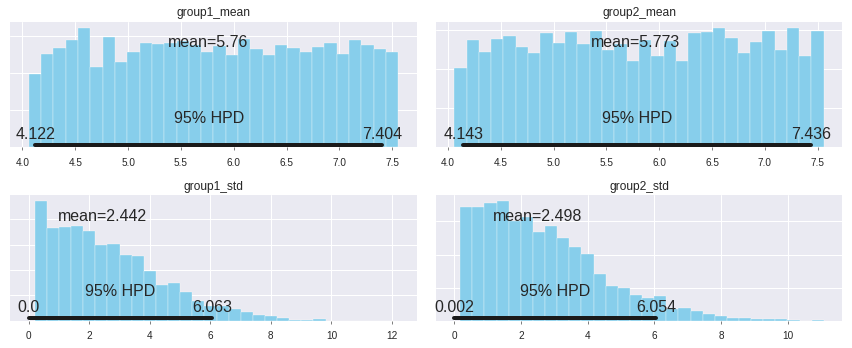

In [12]:
pm.plot_posterior(trace[1000::], 
                  varnames=['group1_mean', 'group2_mean', 'group1_std', 'group2_std'],
                  color='#87ceeb');

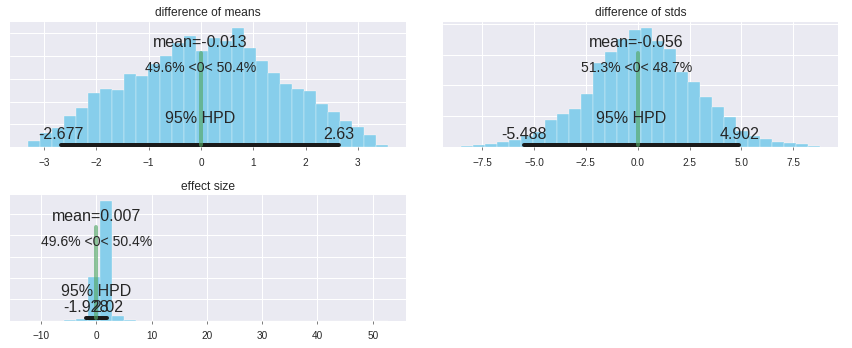

In [13]:
pm.plot_posterior(trace[1000::], 
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

the zero is used as a reference in order to allow cumulative probabilities of the posterior to be distributed on both sides of this value. 

The reference value is within the the 95% HPD interval, we can safely conclude that ther is is now big difference between the two designs.

The analysis did not handle the situation where data sets contain censored records or hierarchical structures in each design. For more information on how to do it, just drop me an email.